In [15]:
%pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

Note: you may need to restart the kernel to use updated packages.


In [16]:
train_data_dir= "../data/raw_data/Training"
test_data_dir = "../data/raw_data/Testing"

In [17]:
# Define the image size and batch size
IMAGE_SIZE =(256,256)
BATCH_SIZE = 16

# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)


X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle =False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=16  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [18]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to transform images into float32
X_train_normalized = X_train.map(normalize_img)
X_val_normalized = X_val.map(normalize_img)

#Apply MRI-specific normalization:
def mri_normalize(image, label):
    """Applies MRI-specific normalization."""
    # Z-score normalization
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    normalized_image = (image - mean) / std
    return normalized_image, label

X_train_normalized = X_train_normalized.map(mri_normalize)
X_val_normalized = X_val_normalized.map(mri_normalize)

Original Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..234.25].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..237.56342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0718765..254.89851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.55225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..245.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..232.25].
Clipping input data to the valid range for

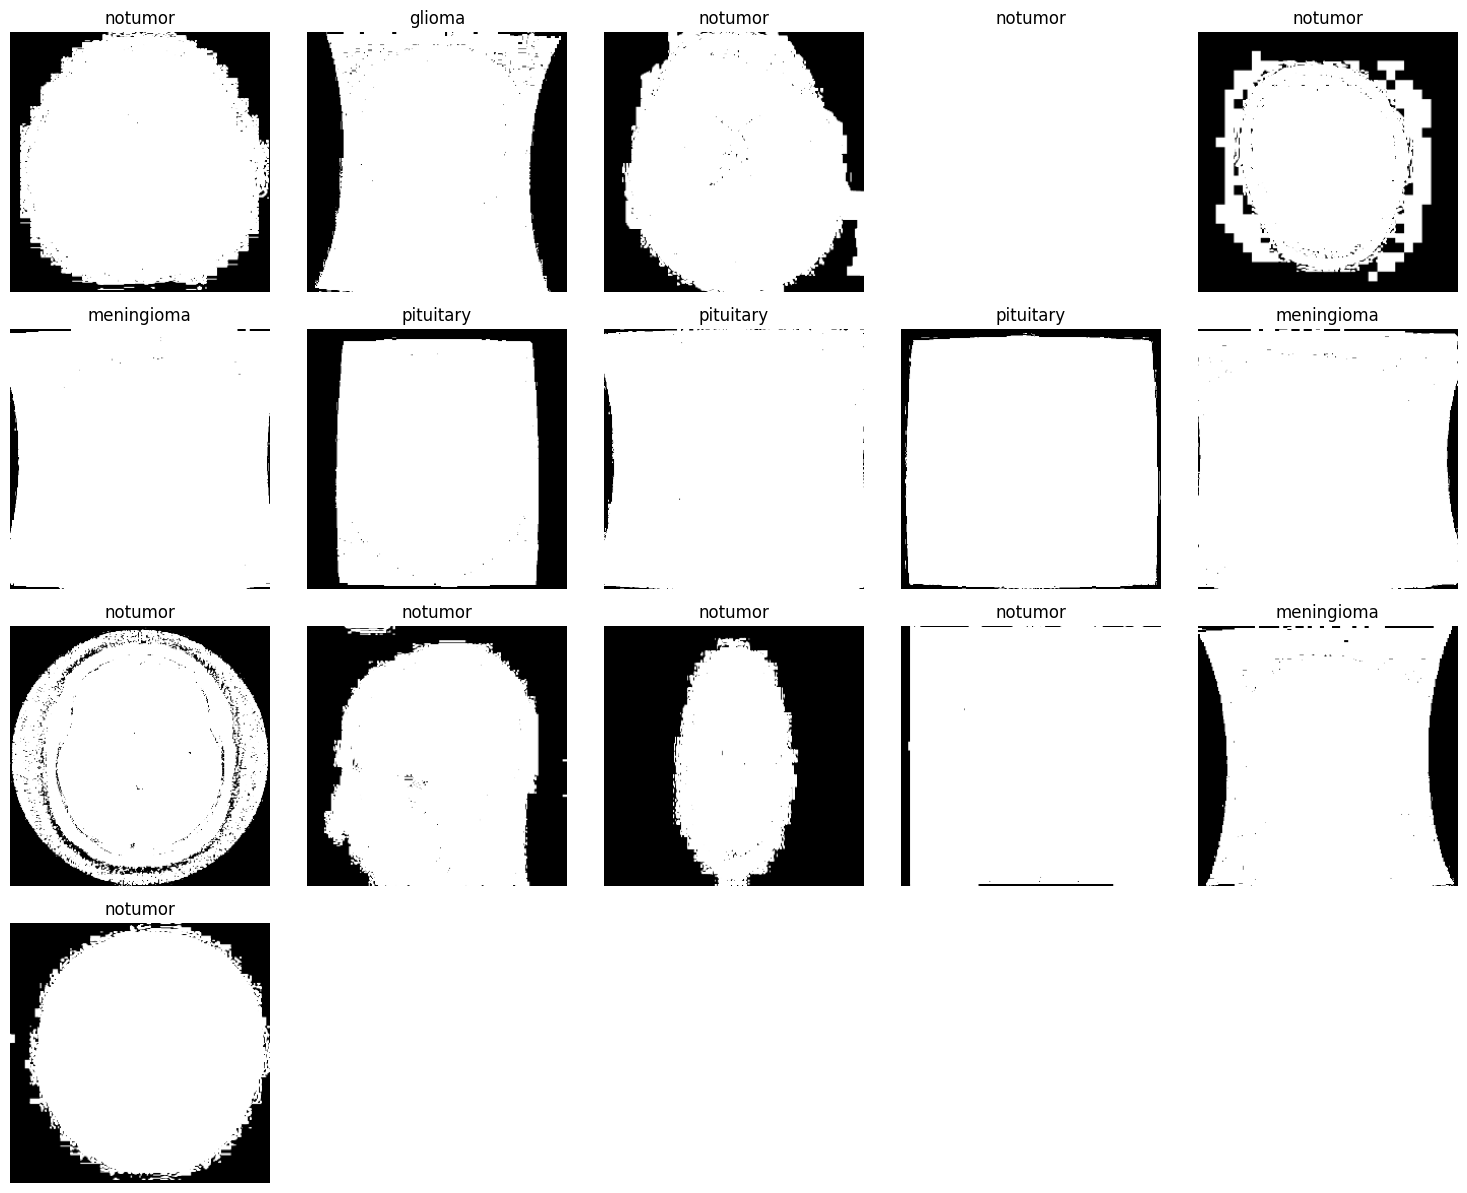

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.234934].


Normalized Data:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.041564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..3.989302].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.156541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.355137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.3133273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.161767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9337887..4.

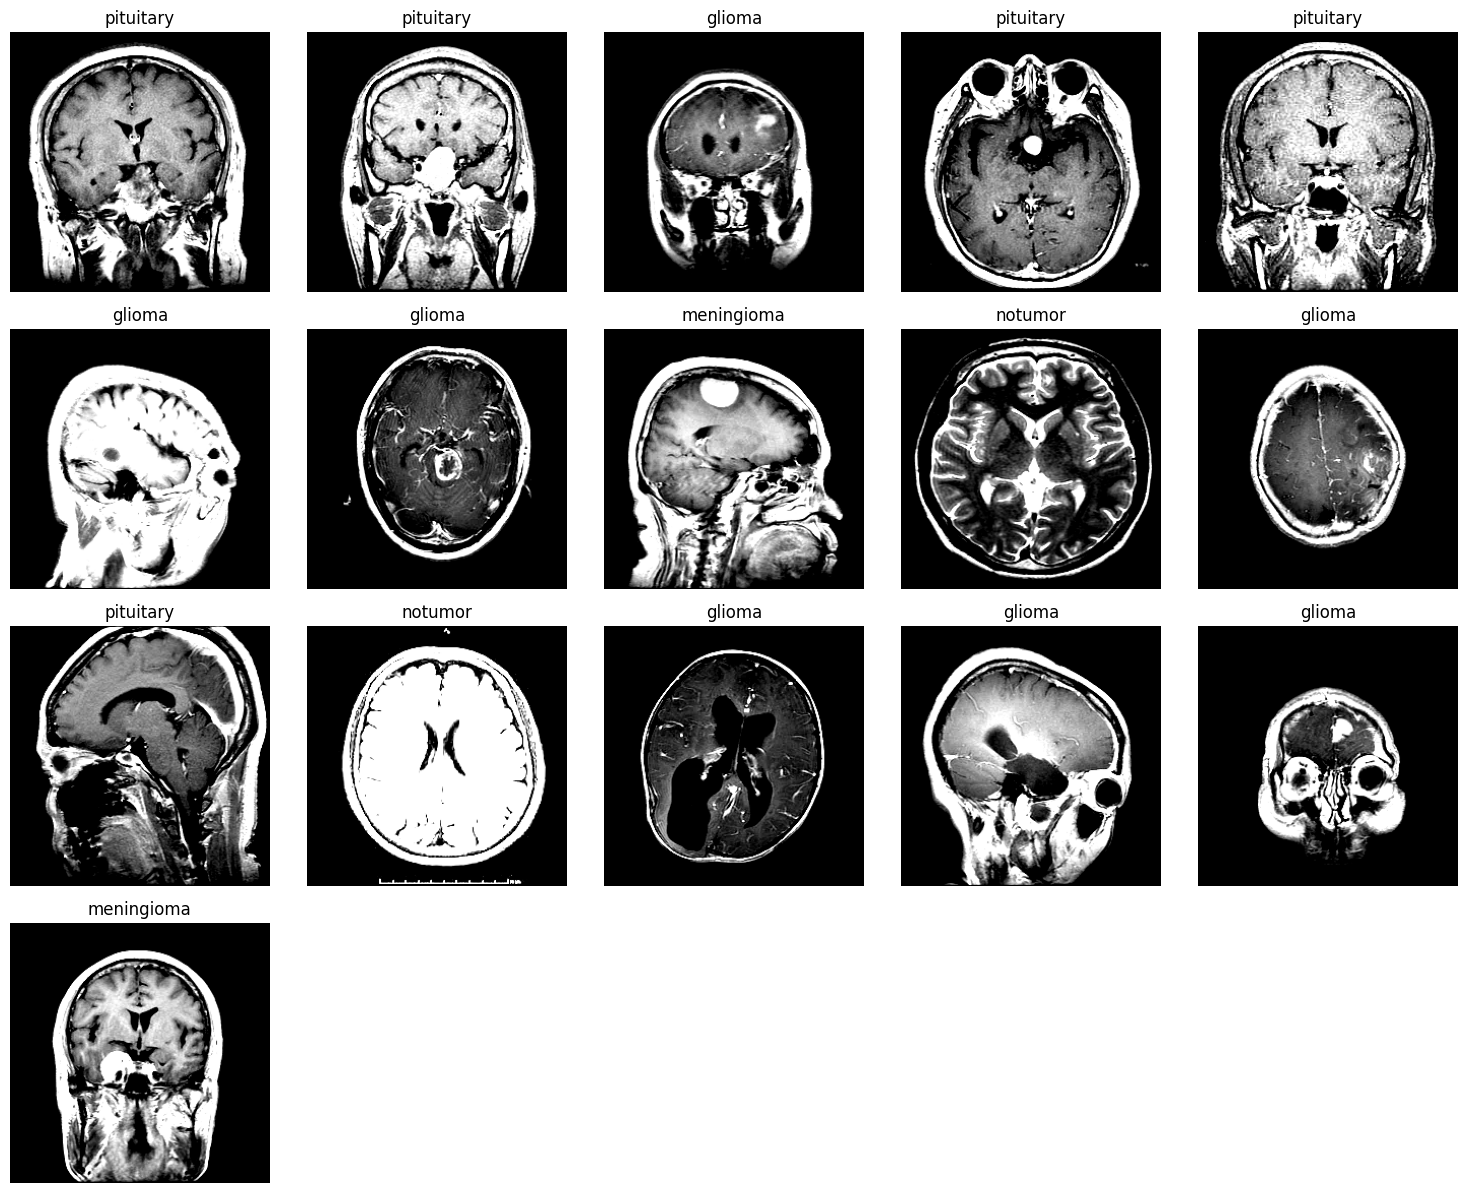

In [19]:

def plot_images_with_labels(dataset, class_names, num_images=25, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("float32"), cmap='gray')
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from the dataset
class_names = X_train.class_names

# Plot original data with labels
print("Original Data:")
plot_images_with_labels(X_train, class_names)

# Plot normalized data with labels
print("Normalized Data:")
plot_images_with_labels(X_train_normalized, class_names)

In [20]:
class_names = X_train.class_names
print(class_names)

def one_hot_encode(image, label):
    # Assuming 'num_classes' is defined
    return image, tf.one_hot(label, depth=len(class_names))

['glioma', 'meningioma', 'notumor', 'pituitary']


In [21]:
num_classes = 0
for _, labels in X_train_normalized.concatenate(X_val):
    num_classes = max(num_classes, tf.reduce_max(labels) + 1)


X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)
# Sequential model
model = models.Sequential()

X_train_encoded = X_train_encoded.shuffle(buffer_size=500).batch(BATCH_SIZE)
X_val_encoded = X_val_encoded.batch(BATCH_SIZE)

In [22]:
import tensorflow as tf

# Define the number of classes (you should know this from your dataset)
num_classes = len(class_names)  # Replace with the actual number of classes

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

# Apply one-hot encoding
X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)

# Shuffle and batch the datasets
X_train_encoded = X_train_encoded.shuffle(buffer_size=500).batch(BATCH_SIZE)
X_val_encoded = X_val_encoded.batch(BATCH_SIZE)

# Define your model (assuming you want a simple CNN for image classification)
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(None, 256, 256, 3)),  # Adjust input shape as needed
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train_encoded,
#                     validation_data=X_val_encoded,
#                     epochs=10)

In [17]:

def baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Conv2D(64, (5, 5), padding='same', activation='relu',
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Conv2D(128, (5, 5), padding='same', activation='relu',
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu',
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),

        #layers.Flatten(),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (256, 256, 3)
num_classes = 4
model = baseline_model(input_shape, num_classes)


In [19]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: val_loss = {logs.get('val_loss')}")

        if logs.get('val_loss') is not None and epoch > 0:
            if logs.get('val_loss') >= self.best_loss:
                self.wait_counter += 1
                print(f"No improvement. Counter = {self.wait_counter}")
                if self.wait_counter >= 5:  # Adjust patience here
                    print("Stopping training due to patience limit.")
                    self.model.stop_training = True
            else:
                print("Improvement observed. Resetting counter.")
                self.wait_counter = 0
                self.best_loss = logs.get('val_loss')
        else:
            self.best_loss = logs.get('val_loss')
            self.wait_counter = 0


custom_early_stopping = CustomEarlyStopping()

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# history = model.fit(
#     X_train,
#     validation_data=X_val,
#     epochs=50,
#     callbacks=[early_stopping]
# )

In [24]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Assuming there are 4 classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train,
                    validation_data=X_test,
                    epochs=50,

    callbacks=[custom_early_stopping])

Epoch 1/50
286/286 [==============================] - 450s 2s/step - loss: 0.6458 - accuracy: 0.7562 - val_loss: 1.2603 - val_accuracy: 0.6079
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8523Epoch 2: val_loss = 2.1704347133636475
No improvement. Counter = 1
286/286 [==============================] - 415s 1s/step - loss: 0.4216 - accuracy: 0.8523 - val_loss: 2.1704 - val_accuracy: 0.4256
Epoch 3/50
286/286 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8926Epoch 3: val_loss = 4.307636737823486
No improvement. Counter = 2
286/286 [==============================] - 409s 1s/step - loss: 0.3083 - accuracy: 0.8926 - val_loss: 4.3076 - val_accuracy: 0.3417
Epoch 4/50
286/286 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9077Epoch 4: val_loss = 2.927717685699463
No improvement. Counter = 3
286/286 [==============================] - 468s 2s/step - loss: 0.2630 - accuracy: 0.9077 - val_loss: 2.9277 

In [25]:
# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                      

In [49]:
model.evaluate(X_test)

82/82 [==============================] - 43s 519ms/step - loss: 0.8599 - accuracy: 0.7361


[0.8598952293395996, 0.7360793352127075]

In [26]:
# Set up directories for saving the model and TensorBoard logs
checkpoint_dir = './checkpoints'
tensorboard_log_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [27]:
callbacks = [
    # Save the model with the minimum valdiation loss
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),

    # Early stopping to stop training when validation loss stops decreasing
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),

    # TensorBoard logging
    TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1, write_images=True)
]

In [28]:
X_train_encoded

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None))>

In [44]:
X_test_encoded = X_test.map(one_hot_encode)
X_test_encoded = X_test_encoded.batch(BATCH_SIZE)

In [48]:
# Evaluate the model on the test dataset
model.evaluate(X_test)

82/82 [==============================] - 34s 417ms/step - loss: 0.8599 - accuracy: 0.7361


[0.8598952293395996, 0.7360793352127075]

In [50]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

NameError: name 'history' is not defined

In [51]:
cnn_checkpoint_dir = './checkpoints'
cnn_model_path = os.path.join(cnn_checkpoint_dir, 'cnn_model.h5')
cnn_model = tf.keras.models.load_model(cnn_model_path)

ValueError: Unrecognized keyword arguments: ['batch_shape']

In [43]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the model
with open('cnn_model.keras', 'rb') as file:
    cnn_model = pickle.load(file)

# Assuming you have your test data prepared
# X_test should be your input images, properly preprocessed
# y_test should be your true labels

# Make predictions
y_pred = cnn_model.predict(X_test)

# If your model outputs probabilities, you might need to convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Visualize some predictions
def plot_predictions(X_test, y_test, y_pred_classes, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"True: {y_test[i]}\nPred: {y_pred_classes[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(X_test, y_test, y_pred_classes)


FileNotFoundError: [Errno 2] No such file or directory: 'cnn_model.keras'

In [ ]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")


Specific Metrics (Training & Validation):


NameError: name 'history' is not defined

In [46]:
cnn_checkpoint_dir = './checkpoints'
cnn_model_path = os.path.join(cnn_checkpoint_dir, 'cnn_model.h5')
cnn_model = tf.keras.models.load_model(cnn_model_path)

OSError: No file or directory found at ./checkpoints/cnn_model.h5

In [36]:
from visualkeras import layered_view
from collections import defaultdict

ModuleNotFoundError: No module named 'visualkeras'

In [110]:
# Customize the color map for different layers
color_map = defaultdict(dict)
# Custom pastel colors
color_map[layers.Conv2D]['fill'] = "#A4D8D0"  # Light Teal (soft and calming)
color_map[layers.BatchNormalization]['fill'] = "#B497D7"  # Soft Lavender (smooth transition)
color_map[layers.MaxPooling2D]['fill'] = "#FFBC80"  # Light Orange (bright accent)
color_map[layers.GlobalAveragePooling2D]['fill'] = "#F9E59E"  # Soft Yellow (light and airy)
color_map[layers.Dropout]['fill'] = "#F7B7A3"  # Soft Peach (warm, welcoming)
color_map[layers.Dense]['fill'] = "#F1A7B7"  # Muted Coral (vibrant yet soft)

# Visualize the model architecture with the custom color map
img = layered_view(best_model, legend=True, max_xy=300, color_map=color_map)

# Display the image
plt.imshow(img)
plt.axis('off')  # Remove axis for cleaner display
plt.show()

NameError: name 'defaultdict' is not defined

In [111]:
# Get the true labels (y_test) from the test generator
y_test = X_test.labels

AttributeError: 'BatchDataset' object has no attribute 'labels'

In [112]:
# Get the predicted probabilities for the test set
y_pred_proba = best_model.predict(X_test, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Proceed to calculate metrics like the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=X_test.class_indices.keys(), yticklabels=X_test.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'best_model' is not defined

In [113]:
# Fetch a batch of images and labels for visualization
test_images, test_labels = next(X_test)

# Predict on the batch
batch_predictions = best_model.predict(test_images)
batch_predicted_classes = np.argmax(batch_predictions, axis=1)

# Visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    true_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[batch_predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

TypeError: 'BatchDataset' object is not an iterator